In [1]:
import os

from collections import Counter

import numpy as np

from PIL import Image

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.functional import char_error_rate

import torchvision

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data_path = "data/CCPD2019-dl1/train/"
test_data_path = "data/CCPD2019-dl1/test/"

In [2]:
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

#### Подготовка данных

In [3]:
train_files = os.listdir(train_data_path)
train_labels = [file[-11:-4] for file in train_files]
test_files = os.listdir(test_data_path)
test_labels = [file[-11:-4] for file in test_files]

counter = Counter()
for label in train_labels + test_labels:
    counter.update(label)

In [4]:
class Tokenizer:
    def __init__(self, counter):
        self.encode_dict = dict()
        self.encode_dict['^'] = 0
        for i, char in enumerate(counter.keys()):
            self.encode_dict[char] = i + 1
        self.decode_dict = dict((v, k) for k, v in self.encode_dict.items())
    
    def tokenize(self, text):
        tokenized = [self.encode_dict[c] for c in text]
        return tokenized
    
    def detokenize(self, tokenized):
        tokenized = tokenized.to('cpu').tolist()
        decoded = list()
        for i in range(len(tokenized)):
            if not (i > 0 and tokenized[i] == tokenized[i - 1]) and tokenized[i] != 0:
                decoded.append(self.decode_dict[tokenized[i]])
        return ''.join(decoded)

In [5]:
tokenizer = Tokenizer(counter)

In [6]:
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=False):
        super().__init__()
        self.data_path = data_path
        self.transform = transform
        self.files = os.listdir(self.data_path)
        self.labels = list()
        self.tokenized_labels = list()
        self.images = list()
        for file in tqdm(self.files):
            self.labels.append(file[-11:-4])
            self.tokenized_labels.append(tokenizer.tokenize(file[-11:-4]))
            image = Image.open(f'{self.data_path}{file}').resize((200, 32))
            image = torchvision.transforms.ToTensor()(image)
            self.images.append(image)
            del image
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, indx):
        # image = Image.open(f'{self.data_path}{self.files[indx]}').resize((200, 32))
        # image = torchvision.transforms.ToTensor()(image)
        label = self.labels[indx]
        return self.images[indx], label, torch.LongTensor(self.tokenized_labels[indx])

In [7]:
train_dataset = OCRDataset(train_data_path)
test_dataset = OCRDataset(test_data_path)

  0%|          | 0/199980 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

#### Создание и обучение модели

In [8]:
class Collator:
    def __call__(self, batch):
        images, texts, encoded = zip(*batch)
        return [torch.stack(images, 0), texts, pad_sequence(encoded, batch_first=True, padding_value=0)]

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128, 
                                               shuffle=True,
                                               collate_fn=Collator())

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=128, 
                                              shuffle=False,
                                              collate_fn=Collator())

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1,2), stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=1, padding=0)

    def forward(self, x):
        x = self.maxpool1(self.relu(self.conv1(x)))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.batchnorm3(self.relu(self.conv3(self.relu(x)))))
        x = self.relu(self.conv4(x))
        return x

In [11]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

In [12]:
class ConvBiLSTM(nn.Module):
    def __init__(self, alphabet_size, number_of_features=16, hidden_size=128, lstm_num_layers=2):
        super().__init__()
        self.encoder = Encoder() 
        self.avg_pool = nn.AdaptiveAvgPool2d((number_of_features, number_of_features))
        self.decoder = Decoder(number_of_features, hidden_size, lstm_num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, number_of_features),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(number_of_features, alphabet_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.decoder(x)
        x = self.classifier(x)
        x = x.permute(1, 0, 2)
        x = nn.functional.log_softmax(x, dim=2)
        return x

In [13]:
model = ConvBiLSTM(len(tokenizer.encode_dict))
model.to(device)

ConvBiLSTM(
  (encoder): Encoder(
    (relu): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(16, 16))
  (decoder): Decoder(
    (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=Tr

In [14]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, verbose=True)

In [15]:
def train_epoch(model, train_loader, optimizer, criterion):
    epoch_loss = 0
    total_step = len(train_loader)
    model.train()
    for (images, labels, tokenized_labels) in tqdm(train_loader):
        batch_size = images.shape[0]
        images = images.to(device)
        tokenized_labels = tokenized_labels.to(device)
        outputs = model(images)
        input_lengths = torch.full(size=(batch_size, ), fill_value=outputs.size(0), dtype=torch.long)
        target_lengths = torch.full(size=(batch_size, ), fill_value=tokenized_labels.size(1), dtype=torch.long)
        loss = criterion(outputs, tokenized_labels, input_lengths, target_lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / total_step

In [16]:
def val_epoch(model, test_loader):
    epoch_loss = 0
    preds = list()
    total_step = len(test_loader)
    model.eval()
    for (images, labels, tokenized_labels) in tqdm(test_loader):
        with torch.inference_mode():
            batch_size = images.shape[0]
            images = images.to(device)
            tokenized_labels = tokenized_labels.to(device)
            outputs = model(images)
            input_lengths = torch.full(size=(batch_size, ), fill_value=outputs.size(0), dtype=torch.long)
            target_lengths = torch.full(size=(batch_size, ), fill_value=tokenized_labels.size(1), dtype=torch.long)
            loss = nn.CTCLoss(blank=0)(outputs, tokenized_labels, input_lengths, target_lengths)
            epoch_loss += loss.item()
            preds.extend(outputs.argmax(2).T)
    return epoch_loss / total_step, preds

In [17]:
torch.cuda.empty_cache()

epoches = 9

label_test = np.array(test_dataset.labels)

for i in tqdm(range(epoches)):
    decoded = list()
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
    test_loss, test_preds = val_epoch(model, test_dataloader)
    test_preds = np.array(list(map(tokenizer.detokenize, test_preds)))
    accuracy = accuracy_score(label_test, test_preds)
    cer = char_error_rate(label_test, test_preds).item()
    scheduler.step(test_loss)
    print(f'epoch: {i}\ntrain loss: {train_loss}, test loss: {test_loss},\n' \
          f'test accuracy: {accuracy}, test CER: {cer}')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 0
train loss: 1.9741555685540917, test loss: 0.2182020671382735,
test accuracy: 0.843984398439844, test CER: 0.03063773177564144


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 1
train loss: 0.20897218624102482, test loss: 0.0839329337866246,
test accuracy: 0.9253925392539254, test CER: 0.01411899458616972


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 2
train loss: 0.1042920543656697, test loss: 0.07717704445217984,
test accuracy: 0.9326932693269326, test CER: 0.012450448237359524


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 3
train loss: 0.06427189640781854, test loss: 0.08809179633478575,
test accuracy: 0.9343934393439344, test CER: 0.012873753905296326


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 4
train loss: 0.047130875217341606, test loss: 0.07683892170839672,
test accuracy: 0.9409940994099409, test CER: 0.01099293865263462


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 5
train loss: 0.033773337547462944, test loss: 0.07241470857134348,
test accuracy: 0.9478947894789479, test CER: 0.00960217509418726


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 6
train loss: 0.029231307204033385, test loss: 0.08088878692640582,
test accuracy: 0.9428942894289429, test CER: 0.010706271044909954


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 7
train loss: 0.025444111202248227, test loss: 0.05929610795117443,
test accuracy: 0.9562956295629563, test CER: 0.008215576410293579


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 8
train loss: 0.022818937908109665, test loss: 0.04697496036385905,
test accuracy: 0.9622962296229624, test CER: 0.007105481345206499


#### Подсчет метрик

Accuracy

In [18]:
accuracy_score(label_test, test_preds)

0.9622962296229624

CER

In [19]:
char_error_rate(label_test, test_preds).item()

0.007105481345206499

#### Анализ ошибок модели

In [20]:
all_cer = list()
for i in range(len(label_test)):
    cer = char_error_rate(label_test[i], test_preds[i]).item()
    if cer > 0:
        all_cer.append((cer, i))
all_cer.sort(key=lambda x: x[0], reverse=True)

In [21]:
print(all_cer[:5])

[(1.5, 3791), (0.8333333134651184, 1750), (0.8333333134651184, 8416), (0.800000011920929, 9821), (0.75, 2189)]


Предсказание: 皖154
Правильный ответ: 皖AK927W


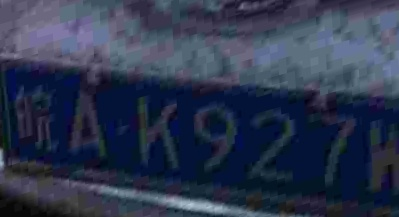

In [22]:
print(f'Предсказание: {test_preds[3791]}\nПравильный ответ: {label_test[3791]}')
Image.open(test_data_path + test_dataset.files[3791])

Предсказание: 皖A3SDS
Правильный ответ: 皖A2W003


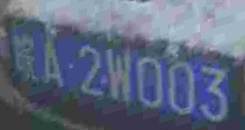

In [23]:
print(f'Предсказание: {test_preds[1750]}\nПравильный ответ: {label_test[1750]}')
Image.open(test_data_path + test_dataset.files[1750])

Предсказание: 皖A45C8
Правильный ответ: 皖A345C7


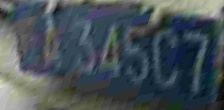

In [24]:
print(f'Предсказание: {test_preds[2662]}\nПравильный ответ: {label_test[2662]}')
Image.open(test_data_path + test_dataset.files[2662])

Предсказание: 皖AG43ZT
Правильный ответ: 皖AG737T


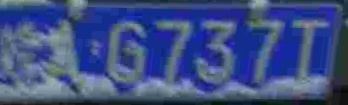

In [25]:
print(f'Предсказание: {test_preds[7004]}\nПравильный ответ: {label_test[7004]}')
Image.open(test_data_path + test_dataset.files[7004])

Модель ошибается больше всего на изображениях, которые имеют очень низкое качество или где некоторые символы просто не видны.
Научить модель распознавать номер на изображениях, где символы не видны почти невозможно, но можно улучшить решения для изображений с низким качеством.

Пути устранения:

1) Использовать другие подходы вместо CTC-Loss. Например, RNN-T. Таким образом модель научиться запоминать в каких местах у нас обычно буквы, а в каких цифры. И может найдет другие, более сложные зависимости.

2) Улучшить архитектуру encoder'а. Можно использовать в качестве encoder'a ResNet, VGG, etc., также можно брать модели предобученные на различных датасетах.

3) Добавить аугментации. Возможно, если разнообразить датасет различными аугментациями, которые изменяют яркость изображения, то некоторые символы модель научиться распознавать более точно.

4) Добавить Test Time Augmentation (TTA). При выполнении предыдущего условия, можно легко увеличить score модели просто добавив аугментации во время инференса модели. Т.е. модель будет делать предсказание на обычном изображении, ярком и т.д., потом выполняем soft-voting и получаем более точное предсказание.

5) Поменять decoder на какую-нибудь более сложную модель - например, BERT. Да, это даст небольшой прирост к score'у, ведь у нас мало контекстной информации, но рост метрики - это рост метрики :)